In [2]:
import ipdb
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pylab as pylab
import cartopy
import cartopy.crs as ccrs
from utils import constants as cnst
from eod import msg
from utils import u_grid, u_interpolate as u_int, u_darrays as uda, u_arrays as ua
import datetime
import matplotlib.colors as mcolors
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
from utils import u_plot as uplot
import salem
import numpy.ma as ma
from scipy import stats
import warnings
from scipy.ndimage.measurements import label

pylab.rcParams['figure.figsize'] = (50., 50.)
%matplotlib inline

In [1]:
cd ..

/home/ck/pythonWorkspace/proj_CEH


In [29]:
corr_all = xr.open_dataset('/home/ck/DIR/mymachine/CHIRPS/peru/CHIRPS_u200_correlation_peruBIG_1981-2018_diffs.nc')
#corr_all = xr.open_dataset('/home/ck/DIR/mymachine/GPM/GPM_u_correlation_SouthAmerica_2000-2018.nc')

In [32]:
corr_all = corr_all.assign_coords(dayofyear=corr_all.dayofyear.values).sel(latitude=slice(-28,0), longitude=slice(-81,-62))

In [33]:
corr_all

<xarray.Dataset>
Dimensions:    (dayofyear: 365, latitude: 101, longitude: 65)
Coordinates:
  * longitude  (longitude) float32 -81.0 -80.75 -80.5 ... -65.5 -65.25 -65.0
  * latitude   (latitude) float32 -25.0 -24.75 -24.5 -24.25 ... -0.5 -0.25 0.0
    level      int32 250
  * dayofyear  (dayofyear) int64 0 1 2 3 4 5 6 7 ... 358 359 360 361 362 363 364
Data variables:
    pval       (dayofyear, latitude, longitude) float64 ...
    r          (dayofyear, latitude, longitude) float64 ...
    slope      (dayofyear, latitude, longitude) float64 ...
    intercept  (dayofyear, latitude, longitude) float64 ...
Attributes:
    years:    [1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991 1992 19...

In [42]:
def find_doy(corr_all, gt_doy=None, lt_doy=None):
    
    if gt_doy is not None:
        mask = corr_all.dayofyear>gt_doy
        pindex = 0
        rcheck = -60
    if lt_doy is not None:
        mask = corr_all.dayofyear<lt_doy
        pindex = -1
        rcheck = 60
        
    corr = corr_all.sel(dayofyear=mask)
    corr_sig = corr.where(corr['pval']<=0.05)
   
    array = corr_sig['r'].values

    thresh = -0.1  # rainfall correlation is negative
    array[array >= thresh] = 0  # T threshold maskout
    array[np.isnan(array)] = 0  # set ocean nans to 0
    outarr_3 = np.zeros((array.shape[1], array.shape[2]))
    outarr_5 = np.zeros((array.shape[1], array.shape[2]))

    for x in range(array.shape[2]):
        for y in range(array.shape[1]):
            ts = array[:,y,x]
            labels, numL = label(ts)

            u, inv = np.unique(labels, return_inverse=True)
            n = np.bincount(inv)

            inds_3 = u[(n>=3)&(u!=0)]
            inds_5 = u[(n>=5)&(u!=0)]
            

            if len(inds_3)>0:
                pos3 = np.where(labels==inds_3[pindex])
                day3 = ((corr_sig.dayofyear.values+1)[(pos3[0])[pindex]])
            else:
                day3 = np.nan

            if len(inds_5)>0:
                pos5 = np.where(labels==inds_5[pindex])
                day5 = ((corr_sig.dayofyear.values+1)[pos5[0][pindex]])
            else:
                day5 = np.nan

            if (pindex==0) & (np.sum(array[rcheck::,y,x]==0)>=15):
                day3 = np.nan
                day5 = np.nan
            if (pindex==-1) & (np.sum(array[::rcheck,y,x]==0)>=15):
                day3 = np.nan
                day5 = np.nan

            outarr_3[y,x] = day3
            outarr_5[y,x] = day5

    return outarr_3, outarr_5

In [43]:
outarr_3, outarr_5 = find_doy(corr_all, gt_doy=182)

In [44]:
endarr_3, endarr_5 = find_doy(corr_all, lt_doy=182)

In [45]:
topo = xr.open_dataarray(cnst.TOPO_1MIN).sel(lon=slice(-83,-55), lat=slice(-26,7))
topo_on_g = corr_all.salem.lookup_transform(topo)

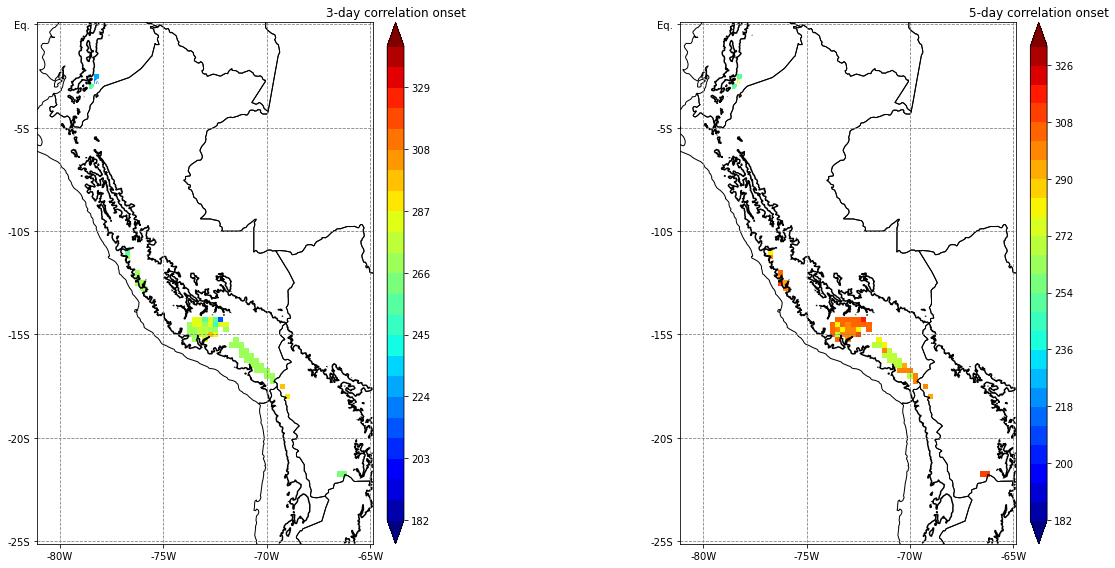

In [46]:
map = corr_all.salem.get_map()
f = plt.figure(figsize=(20,8))

ax = f.add_subplot(121)

map.set_data(outarr_3)
map.set_plot_params(levels=np.arange(182,350,7), cmap='jet', extend='both') #[182,213,244,274,305,335, 366]
map.set_contour(topo, interp='linear', levels=[900,3000], cmap='Greys')
map.visualize()
plt.plot(-77.5, -9.5, 'ro')
plt.title('3-day correlation onset')

ax = f.add_subplot(122)

map.set_data(outarr_5)
map.set_plot_params(levels=np.arange(182, 335, 6), cmap='jet', extend='both')
map.set_contour(topo, interp='linear', levels=[900,3000], cmap='Greys')
map.visualize()
plt.plot(-77.5, -9.5, 'ro')
plt.title('5-day correlation onset')

plt.tight_layout()

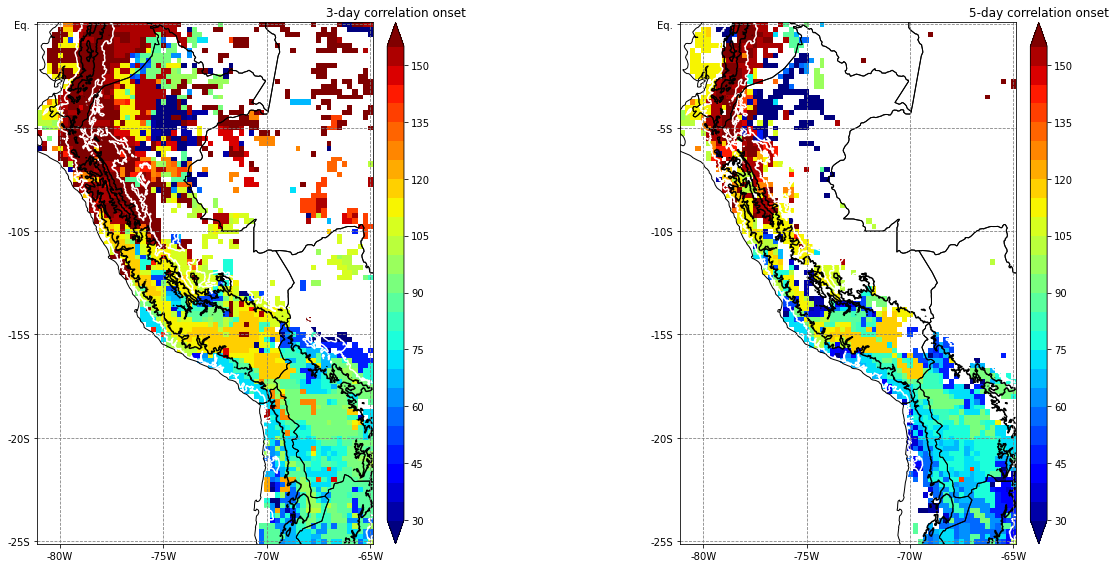

In [47]:
map = corr_all.salem.get_map()
f = plt.figure(figsize=(20,8))

ax = f.add_subplot(121)

map.set_data(endarr_3)
map.set_plot_params(levels=np.arange(30,156,5), cmap='jet', extend='both') #[182,213,244,274,305,335, 366]
map.set_contour(topo, interp='linear', levels=[900,3000], cmap='Greys')
map.visualize()
plt.plot(-77.5, -9.5, 'ro')
plt.title('3-day correlation onset')

ax = f.add_subplot(122)

map.set_data(endarr_5)
map.set_plot_params(levels=np.arange(30,156,5), cmap='jet', extend='both')
map.set_contour(topo, interp='linear', levels=[900,3000], cmap='Greys')
map.visualize()
plt.plot(-77.5, -9.5, 'ro')
plt.title('5-day correlation onset')

plt.tight_layout()

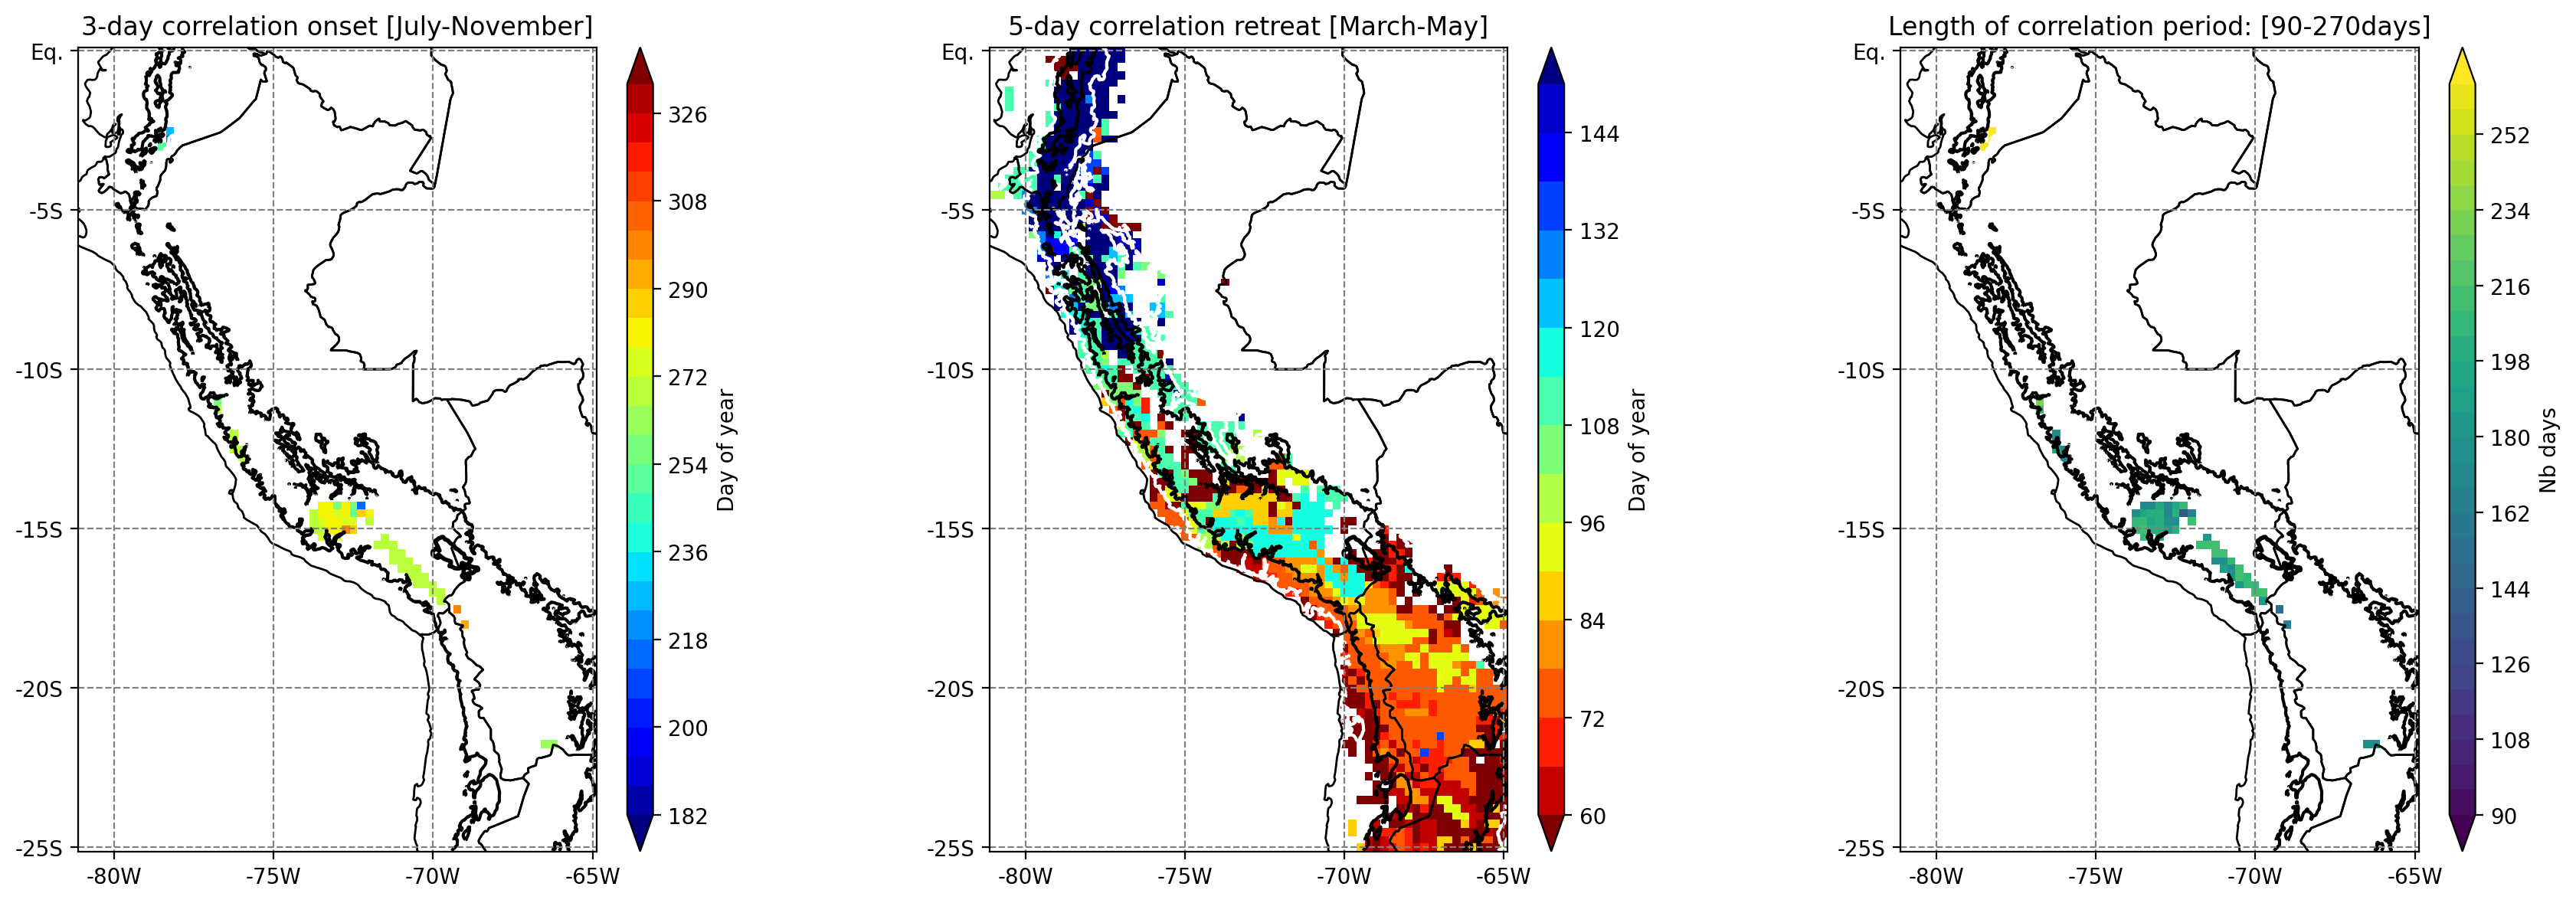

In [48]:
lakes = salem.read_shapefile(salem.get_demo_file('ne_50m_lakes.shp'),
                              cached=True)


map = corr_all.salem.get_map()
f = plt.figure(figsize=(18,6), dpi=200)

ax = f.add_subplot(131)

map.set_data(outarr_3)
map.set_plot_params(levels=np.arange(182,335,6), cmap='jet', extend='both') #[182,213,244,274,305,335, 366]  # 182-July, 335- December
map.set_contour(topo, interp='linear', levels=[900,3000], cmap='Greys')
map.set_shapefile(lakes, edgecolor='k', facecolor='none', linewidth=2)
plt.plot(-77.5, -9.5, 'ro', markersize=5)
map.visualize(cbar_title='Day of year', title='3-day correlation onset [July-November]')

ax = f.add_subplot(132)
endarr_5[(topo_on_g<300)]=np.nan # | (endarr_5<65)
map.set_data(endarr_5)
map.set_plot_params(levels=np.arange(60,152,6), cmap='jet_r', extend='both') # 60 March, 152 June
map.set_contour(topo, interp='linear', levels=[900,3000], cmap='Greys')
map.visualize(cbar_title='Day of year', title='5-day correlation retreat [March-May]')
plt.plot(-77.5, -9.5, 'ro', markersize=5)

ax = f.add_subplot(133)
endarr_5[(topo_on_g<300)]=np.nan # | (endarr_5<65)
map.set_data((365-outarr_3)+endarr_5)
map.set_plot_params(levels=np.arange(90,270,6), cmap='viridis', extend='both')
map.set_contour(topo, interp='linear', levels=[900,3000], cmap='Greys')
map.visualize(cbar_title='Nb days', title='Length of correlation period: [90-270days]')
plt.plot(-77.5, -9.5, 'ro', markersize=5)

plt.tight_layout()
#plt.savefig('/home/ck/DIR/cornkle/figs/HUARAZ/correlations/CHIRPS_u200_CCT_correlation_1984-2019.png')

In [41]:
ispos = corr_all.isel(dayofyear=1).where((corr_all.longitude==-77.75)&(corr_all.latitude==-9.5))
pickpos = np.where(np.isfinite(ispos['r']))

y = int(pickpos[0])
x = int(pickpos[1])

date = pd.datetime(2017, 1, 1) + pd.Timedelta(str(outarr_3[y,x] - 1)+' days')
dstr = date.strftime("%d/%m")
print('Huaraz onset', outarr_3[y,x], 'Date', dstr)
date = pd.datetime(2017, 1, 1) + pd.Timedelta(str(endarr_5[y,x] - 1)+' days')
dstr = date.strftime("%d/%m")
print('Huaraz retreat', endarr_5[y,x], 'Date', dstr)

Huaraz onset 253.0 Date 10/09
Huaraz retreat 113.0 Date 23/04


/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  import sys
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  # Remove the CWD from sys.path while we load stuff.
